<h1 style="text-align: center; font-weight: bold;">Amirali Rahimi 810100146</h1>
<h1 style="text-align: center;">CA2 - Reinforcement Learning</h1>

# Table of Contents

- [Part 1: Value Iteration & Policy Iteration Algorithms](#1)
    - [Question 1:](#1-0)
    - [َQuestion 2:](#1-1)
    - [َQuestion 3:](#1-12)
    - [َQuestion 4:](#1-2)
    - [َQuestion 5:](#1-3)
        - [Value Iteration](#1-3-1)
        - [Policy Iteration](#1-3-2)
    - [َQuestion 6:](#1-4)
        - [Value Iteration](#1-4-1)
        - [Policy Iteration](#1-4-2)
- [Part 2: Q-Learning Algorithm](#2)
    - [َQuestion 8:](#2-1)
    - [َQuestion 9:](#2-2)
    - [َQuestion 10:](#2-3)

In [22]:
import numpy as np
import gymnasium as gym
import pygame
from tabulate import tabulate
import matplotlib.pyplot as plt
from typing import List
import random
import time

## Part 1: Value Iteration & Policy Iteration Algorithms

<a name='1-0'></a>
### Question 1:

#### What is Value Iteration and how we get to optimal policy through this method?
The goal of value iteration is to calculate the `utility of each state` which is defined as the expected sum of discounted rewards from that state onward. `Bellman equation` charactrize optimal values:
$$ V^*(s) =  max_a\displaystyle\sum_{s'} \biggl[T(s,a,s') \Bigl( R(s,a,s')+\gamma V^*(s')\Bigr)\biggr]$$
 The method to calculate the utilty for each state, is to `iterate through all states and calculate their utility value from what we have so far` for all the other states and when we did this for all states, we start over. (We start with $V_{0}(s)=0$ for all states)
$$ V_{k+1}(s) =  max_a\displaystyle\sum_{s'} \biggl[T(s,a,s') \Bigl( R(s,a,s')+\gamma V_k(s')\Bigr)\biggr]$$
Finally, for extracting optimal policy from `state values`, we need to do a mini-expectimax:
$$ \pi^*(s) =  argmax_a\displaystyle\sum_{s'} \biggl[T(s,a,s') \Bigl( R(s,a,s')+\gamma V^*(s')\Bigr)\biggr]$$
Or if we have calculated optimal `q-values`, we can easily extract actions from those:
$$ \pi^*(s) =  argmax_a Q^*(s,a)$$

<a name='1-1'></a>
### Question 2:

In [23]:
class ValueIteration():
    def __init__(self, env, discount_factor, theta=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.reset()
        self.state_values = np.ones((self.env.observation_space.n)) / self.env.action_space.n
        self.q_values = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        self.state_values[self.env.observation_space.n - 1] = 0
        self.q_values[self.env.observation_space.n - 1] = np.zeros((self.env.action_space.n))

    def value_estimation(self):
        self.delta = np.inf
        steps = 0
        while(self.delta > self.theta):
            steps = steps + 1
            self.delta = 0
            for state in range(self.env.observation_space.n):

                v = self.state_values[state]

                for action in range(self.env.action_space.n):
                    action_value = 0
                    for probability, next_state, reward, done in self.env.P[state][action]:
                        action_value += probability*(reward+(self.discount_factor*self.state_values[next_state]))
                    self.q_values[state, action] = action_value

                self.state_values[state] = np.max(self.q_values[state,:])

                self.delta = np.max([self.delta, abs(v - self.state_values[state])])

        return steps

    def take_action(self, action):
        next_state, reward, done, _, _ = self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return np.argmax(self.q_values[state,:])

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        initial_state, _ = self.env.reset()
        return initial_state
    
    def get_all_optimal_policy(self):
        policy = []
        for state in range(self.env.observation_space.n):
            policy.append(self.get_optimal_policy(state))
        return policy

<a name='1-12'></a>
### Question 3:

#### What is Policy Iteration and how we get to optimal policy through this method?   
The goal of policy iteration is to `find the optimal policy` of a given MDP problem. Which has 2 steps:
- *`Policy Evaluation:`* Calculates utilities for a `fixed policy` which we can use Bellman Equation here:
$$ V^{\pi}(s) = \displaystyle\sum_{s'} \biggl[T(s,\pi(s),s') \Bigl( R(s,\pi(s),s')+\gamma V^{\pi}(s')\Bigr)\biggr]$$
We calculate this after `doing a policy improvement` and a iteration over states:(until convergence)
$$ V_{k+1}^{\pi_i}(s) = \displaystyle\sum_{s'} \biggl[T(s,\pi_i(s),s') \Bigl( R(s,\pi_i(s),s')+\gamma V_{k}^{\pi_i}(s')\Bigr)\biggr]$$
- *`Policy Improvemnet:`* Update policy using `one-step look-ahead`(to calculated utilities) to replace the initial policy:
$$ \pi_{i+1}(s) = argmax_a\displaystyle\sum_{s'} \biggl[T(s,a,s') \Bigl( R(s,a,s')+\gamma V^{\pi_i}(s')\Bigr)\biggr]$$


<a name='1-2'></a>
### Question 4:

In [24]:
class PolicyIteration():
    def __init__(self, env, discount_factor, theta=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.reset()
        self.state_values = np.ones((self.env.observation_space.n)) / self.env.action_space.n
        self.q_values = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        self.state_values[self.env.observation_space.n - 1] = 0
        self.q_values[self.env.observation_space.n - 1] = np.zeros((self.env.action_space.n))
        self.policy = np.random.randint(self.env.action_space.n, size=self.env.observation_space.n) # initial policy
        self.policy_stable = False

    def policy_evaluation(self):
        self.delta = np.inf
        steps = 0
        while(self.delta >= self.theta):
            steps += 1
            self.delta = 0
            
            for state in range(self.env.observation_space.n):
                v = self.state_values[state]
                new_state_value = 0
                for probability, next_state, reward, done in self.env.P[state][self.policy[state]]:
                    new_state_value += probability*(reward+(self.discount_factor*self.state_values[next_state]))
                self.state_values[state] = new_state_value
                
                self.delta = np.max([self.delta, abs(v - self.state_values[state])])
        return steps

    def policy_improvement(self):
        self.policy_stable = True

        for state in range(self.env.observation_space.n):
            old_policy = self.policy[state]

            for action in range(self.env.action_space.n):

                action_value = 0
                for probability, next_state, reward, done in self.env.P[state][action]:
                    action_value += probability*(reward+(self.discount_factor*self.state_values[next_state]))
                self.q_values[state, action] = action_value

            self.policy[state] = np.argmax(self.q_values[state,:])

            if old_policy != self.policy[state]:
                self.policy_stable = False

    def policy_estimation(self):
        self.policy_stable = False
        steps = 0
        while not self.policy_stable:
            steps += self.policy_evaluation()
            self.policy_improvement()
            steps += 1 #because every policy_improvemnet has a O(SA) time complexity
        return steps

    def take_action(self, action):
        next_state, reward, done, _, _ = self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return self.policy[state]

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        initial_state, _ = self.env.reset()
        return initial_state
    
    def get_all_optimal_policy(self):
        policy = []
        for state in range(self.env.observation_space.n):
            policy.append(self.get_optimal_policy(state))
        return policy

<a name='1-3'></a>
### Question 5:

Here we have 4 auxilary functions:
- `show_state_value`: It makes a heatmap and shows value of each state in that map.
- `int_to_dir`: Extracted policy, is a list of actions which are integers. This function maps each integer to a direction which represents that action.
- `show_optimal_policy`: creates a table and uses `int_to_dir to visualize` the optimal policy.
- `visualize_move`: uses gym environment to render the map of the game and visualize the way our agent acts in this environment.

In [25]:
def show_state_value(state_values):
    state_values = np.array(state_values).reshape(4, 4)
    fig, ax = plt.subplots()
    cax = ax.matshow(state_values, cmap='RdYlGn')
    fig.colorbar(cax)
    for i in range(state_values.shape[0]):
        for j in range(state_values.shape[1]):
            ax.text(j, i, f'{state_values[i, j]:.2f}', va='center', ha='center')
    ax.set_xticks(np.arange(-.5, 4, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 4, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.grid(which='major', color='w', linestyle='-', linewidth=0)
    plt.title('state values')
    plt.show()

In [26]:
def int_to_dir(num):
    if(num == 0): return '←'
    elif(num == 1): return '↓'
    elif(num == 2): return '→'
    elif(num == 3): return '↑'

In [27]:
def show_optimal_policy(optimal_policy):
    new_policy = optimal_policy.copy()
    new_policy = list(map(int_to_dir,  optimal_policy))
    new_policy = np.array(new_policy).reshape(4, 4)
    table = tabulate(new_policy, tablefmt='fancy_grid', floatfmt=".2f")
    print("optimal policy:")
    print(table)

In [28]:
def visualize_moves(rgb_array, frame_rate):
    frame_width,frame_height, _ = rgb_array.shape
    window = pygame.display.set_mode((frame_height, frame_width))
    frame = pygame.surfarray.make_surface(rgb_array)
    frame = pygame.transform.rotate(frame, -90)
    frame = pygame.transform.flip(frame, True, False)
    window.blit(frame, (0, 0))
    pygame.display.flip()
    time.sleep(1 / frame_rate)

In [29]:
def show_for_val_pol(myClass):
    pygame.init()
    frame_rate = 2
    for episode in range(5):
        state = myClass.reset()
        done = False
        while not done:
            best_action = myClass.get_optimal_policy(state)
            next_state, reward, done = myClass.take_action(best_action)
            state = next_state
            rgb_array = myClass.env.render()
            visualize_moves(rgb_array, frame_rate)
    pygame.quit()

<a name='1-3-1'></a>
#### Value Iteration:

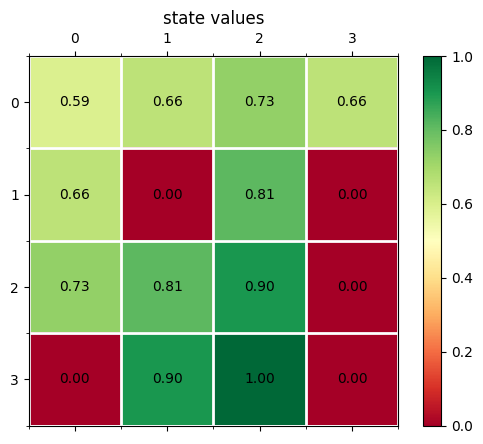

optimal policy:
╒═══╤═══╤═══╤═══╕
│ ↓ │ → │ ↓ │ ← │
├───┼───┼───┼───┤
│ ↓ │ ← │ ↓ │ ← │
├───┼───┼───┼───┤
│ → │ ↓ │ ↓ │ ← │
├───┼───┼───┼───┤
│ ← │ → │ → │ ← │
╘═══╧═══╧═══╧═══╛


In [30]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")
steps_until_converge_vals = []
time_until_converge_vals = []
myVal = None
for _ in range(5):
    myVal = ValueIteration(env, 0.9)
    start_time = time.time()
    steps_until_converge_val = myVal.value_estimation()
    end_time = time.time()
    time_until_converge_vals.append(round(end_time-start_time,3))
    steps_until_converge_vals.append(steps_until_converge_val)
state_values = myVal.get_state_values()
optimal_policy = myVal.get_all_optimal_policy()
show_state_value(state_values)
show_optimal_policy(optimal_policy)
show_for_val_pol(myVal)

<a name='1-3-2'></a>
#### Policy Iteration:

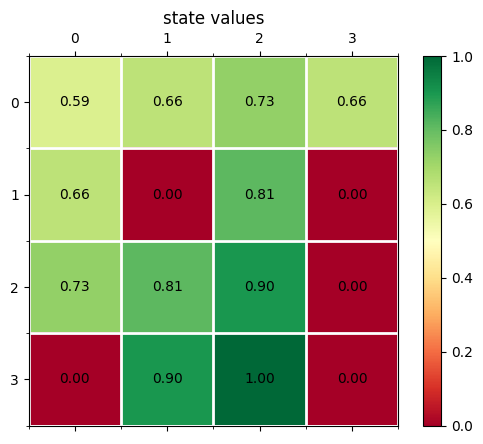

optimal policy:
╒═══╤═══╤═══╤═══╕
│ ↓ │ → │ ↓ │ ← │
├───┼───┼───┼───┤
│ ↓ │ ← │ ↓ │ ← │
├───┼───┼───┼───┤
│ → │ ↓ │ ↓ │ ← │
├───┼───┼───┼───┤
│ ← │ → │ → │ ← │
╘═══╧═══╧═══╧═══╛


In [31]:
steps_until_converge_pols = []
time_until_converge_pols = []
myPol = None
for _ in range(5):
    myPol = PolicyIteration(env, 0.9)
    start_time = time.time()
    steps_until_converge_pol = myPol.policy_estimation()
    end_time = time.time()
    time_until_converge_pols.append(round(end_time-start_time,3))
    steps_until_converge_pols.append(steps_until_converge_pol)
state_values = myPol.get_state_values()
optimal_policy = myPol.get_all_optimal_policy()
show_state_value(state_values)
show_optimal_policy(optimal_policy)
show_for_val_pol(myPol)

<a name='1-4'></a>
### Question 6:

<a name='1-4-1'></a>
#### Value Iteration:

In [32]:
print(f"It took {steps_until_converge_vals} steps until converge in value iteration")
print(f"It took {time_until_converge_vals} secs until converge in value iteration")

It took [141, 141, 141, 141, 141] steps until converge in value iteration
It took [0.073, 0.071, 0.071, 0.071, 0.072] secs until converge in value iteration


<a name='1-4-2'></a>
#### Policy Iteration:

In [33]:
print(f"It took {steps_until_converge_pols} steps until converge in policy iteration")
print(f"It took {time_until_converge_pols} secs until converge in policy iteration")

It took [159, 161, 159, 159, 161] steps until converge in policy iteration
It took [0.03, 0.03, 0.028, 0.028, 0.029] secs until converge in policy iteration


As we can see, the state values and optimal policy for both are exactly the same. And `there is not` a big difference between the itearions over state values in policy iteration and value iteration. The point of using policy iteration over value iteration, is the time each algorithm consumes. As we can see, `every iteration` in `value iteration`, consumes $O(S^2A)$. so the `consumed time` for the value_iteration algorithm to complete is $steps*O(S^2A)$. On the other hand, `every iteration` for `policy iteration`, consumes $O(S^2)$. So the `consumed time` for the policy_iteration algorithm to complete is $steps*O(S^2)$. Which as we can see, policy iteration algorithm took almost $\dfrac{1}{A}$ time of value iteration.

<a name='2'></a>
## Part 2: Q-Learning Algorithm

<a name='2-1'></a>
### Question 7:

#### What is Q-Learning?
`Q-learning` is a model-free reinforcement learning algorithm used to learn the value of an action in a particular state. `It does not require a model` of the environment, hence the term model-free. Executing an action in a specific state provides the agent with a reward. The goal of the agent is to maximize its total reward. In this algorithm, `we update a Q-state` for state s and action a `based on the sample we see`:
$$ sample = R(s,a,s')+\gamma max_{a'}Q(s',a')$$
$$ Q(s,a) = (1-\alpha)Q(s,a) + \alpha[sample]$$


In [34]:
REPS = 20
EPISODES = 2000
EPSILON = 0.1
LEARNING_RATE = 0.1
DISCOUNT = 0.9
STUDENT_NUM = 146

<a name='2-1'></a>
### Question 8:

In [35]:
class QLearningAgent():
    def __init__(self, env, epsilon, learning_rate, discount_factor, seed):
      self.env = env
      self.epsilon = epsilon
      self.initial_epsilon = epsilon
      self.learning_rate = learning_rate
      self.initial_learning_rate = learning_rate
      self.discount_factor = discount_factor
      self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
      self.seed = seed

    def choose_action(self, state):
      random_action = random.randint(0, self.env.action_space.n-1)
      best_action = np.argmax(self.q_table[state,:])
      if(random.random()<self.epsilon):
        action = random_action
      else:
        action = best_action
      return action

    def update_q_table(self, state, action, next_state, reward):
      next_state_best_action = np.argmax(self.q_table[next_state,:])
      self.q_table[state][action] = (1-self.learning_rate)*self.q_table[state][action] \
                                    + self.learning_rate*(reward + self.discount_factor*(self.q_table[next_state][next_state_best_action]))

    def decay_epsilon(self, episode):
      self.epsilon = self.initial_epsilon*(1-episode/EPISODES)

    def decrease_learning_rate(self, episode):
      self.learning_rate = self.initial_learning_rate*(1-episode/EPISODES)

    def take_action(self, action):
      next_state, reward, done, _, _ = self.env.step(action)
      return next_state, reward, done

    def get_optimal_policy(self, state):
      return np.argmax(self.q_table[state])

    def get_q_values(self):
      return self.q_table

    def reset(self):
      initial_state, _ = self.env.reset(seed=self.seed)
      return initial_state

In [36]:
def calc_mean(thisList):
    result = []
    for j in range(EPISODES):
        mean = 0
        for i in range(REPS):
            mean += thisList[i][j]
        mean = mean / REPS
        result.append(mean)
    return result


In [37]:
def show_plot(dec_agent, non_dec_agent, x_name, y_name, title):
    x = list(range(1, len(dec_agent) + 1))
    plt.title(title)
    plt.plot(x, dec_agent, "blue")
    plt.plot(x, non_dec_agent, "red")
    plt.grid()
    plt.legend(["floating learning rate", "fixed learning rate"])
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.xlim([0, 400])
    plt.show()

In [38]:
def teachAgent(env1, decrease_rate):
    total_reward = []
    total_steps = []
    for rep in range(REPS):
        agent = QLearningAgent(env1, EPSILON, LEARNING_RATE, DISCOUNT, STUDENT_NUM)
        rewards = []
        steps = []
        for episode in range(EPISODES):
            state = agent.reset()
            step_in_episode = 0
            reward_in_episode = 0
            for _ in range(100) :
                best_action = agent.choose_action(state)
                next_state, reward, done = agent.take_action(best_action)
                reward_in_episode += reward
                agent.update_q_table(state, best_action, next_state, reward)
                state = next_state
                step_in_episode += 1
                if done:
                    break
            agent.decay_epsilon(episode)
            if(decrease_rate):
                agent.decrease_learning_rate(episode)
            rewards.append(reward_in_episode)
            steps.append(step_in_episode)
        total_reward.append(rewards.copy())
        total_steps.append(steps.copy())
    return agent, total_reward.copy(), total_steps.copy()

In [39]:
env1 = gym.make('Taxi-v3', render_mode = "rgb_array")
agent1, total_reward1, total_steps1 = teachAgent(env1, True)
agent2, total_reward2, total_steps2 = teachAgent(env1, False)


<a name='2-2'></a>
### Question 9:

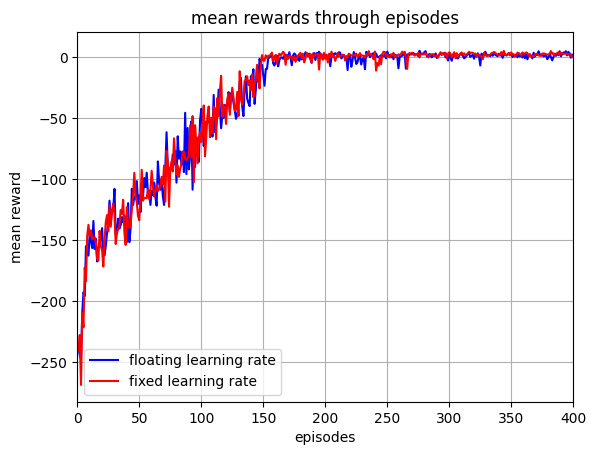

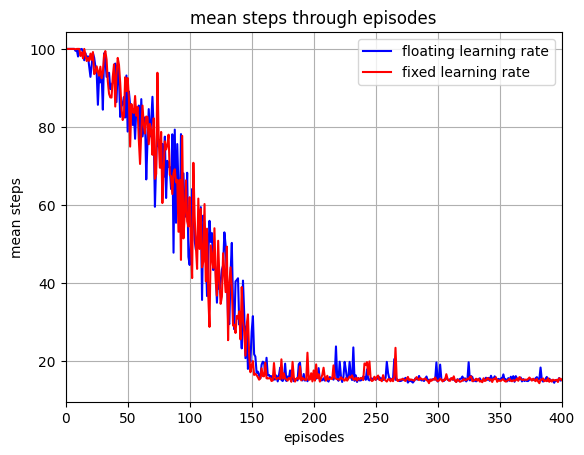

In [40]:
mean_reward1 = calc_mean(total_reward1)
mean_reward2 = calc_mean(total_reward2)
show_plot(mean_reward1, mean_reward2, "episodes", "mean reward", "mean rewards through episodes")

mean_steps1 = calc_mean(total_steps1)
mean_steps2 = calc_mean(total_steps2)
show_plot(mean_steps1, mean_steps2, "episodes", "mean steps", "mean steps through episodes")

 In fact, decreasing the learning rate in Q-learning `can help ensure convergence`, but if decreased too quickly, it can slow down the speed of convergence or even worse, it stop the agent from learning even though the agent is not taught enough. 
 Here, `we got to convergence in both cases` anyway due to the essence of the problem. But we can see bad effects of decreasing the learning rate too quickly by changing the decrease_learning_rate function.  
 The conditions for the learning rate, should be like this:
 - $1.$ Sum of learning rates should diverge.
 $$\displaystyle\sum_{i=0}^{\infty}\alpha_i = \infty$$
 - $2.$ Sum of the squares of learning rates should converge.
 $$\displaystyle\sum_{i=0}^{\infty}\alpha_i^2 < T$$
The formula for decreasing epsilon:
$$\epsilon = initial\;\epsilon*(1-\frac{episode}{EPISODES})$$

<a name='2-3'></a>
### Question 10:

In [41]:
pygame.init()
frame_rate = 2
for episode in range(5):
    state = agent1.reset()
    done = False
    while not done:
        best_action = agent1.choose_action(state)
        next_state, reward, done = agent1.take_action(best_action)
        state = next_state
        rgb_array = agent1.env.render()
        visualize_moves(rgb_array, frame_rate)
pygame.quit()

In [42]:
pygame.init()
frame_rate = 2
for episode in range(5):
    state = agent2.reset()
    done = False
    while not done:
        best_action = agent2.choose_action(state)
        next_state, reward, done = agent2.take_action(best_action)
        state = next_state
        rgb_array = agent2.env.render()
        visualize_moves(rgb_array, frame_rate)
pygame.quit()